# Comment Classifier Using LSTM #

Classifying comments using a form of recurring neural network, the Long Short Term Memory (LSTM) neural network.

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Update these lines:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

### Load Data and see general structure of dataframe

In [112]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
test_labels = pd.read_csv('./Data/test_labels.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [82]:
train.isnull().any()
test.isnull().any()

id              False
comment_text    False
dtype: bool

### Split Dataframe into comment text, and their corresponding toxicity values

In [113]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
y_test = test_labels.values
list_sentences_train = train["comment_text"].fillna("\"")
list_sentences_test = test["comment_text"].fillna("\"")

### Tokenize the words by assigning each word an index and converting each comment into these indicies

In [25]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(list_sentences_train)) #this function ranks words based on frequency, with 1 being the most frequent in the dataset

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train) # converts the comments into integer sequences
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

### Make every comment the same length (pad the shorter ones and trim the longer ones)

We need to keep in mind that a if we trim the long comments prematurely, we may lose out on key information. Therefore, we plot the distribution of lengths of comments to see what number would be optimal.

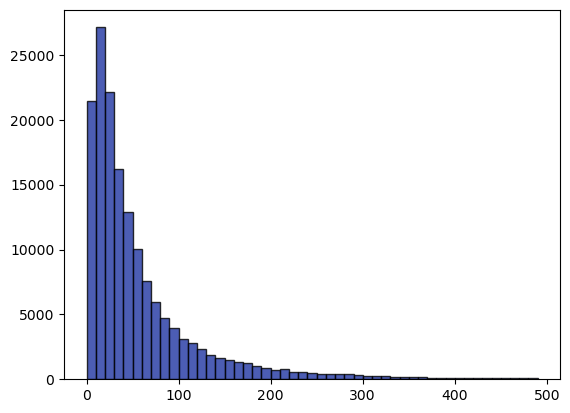

In [34]:
totalNumWords = [len(single_comment) for single_comment in list_tokenized_train]
plt.hist(totalNumWords, 
         bins=np.arange(0, 500, 10),
         edgecolor='black', 
         color='#1f34a2',    
         alpha=0.8)         # Slightly transparent
plt.show()

Based on this, it seems reasonable that at around 200-300, we aren't losing too much information.

In [43]:
maximum_length = 250
x_train = pad_sequences(list_tokenized_train, maxlen=maximum_length)
x_test = pad_sequences(list_tokenized_test, maxlen=maximum_length)

## Model Section

General architecture: Input -> Embedding -> LSTM -> Max Pooling -> Dropout -> Dense -> Dropout -> Dense

Our first layer is the input layer, which takes a number of sentences, where each one has a maximum length of 250.

In [44]:
inp = Input(shape=(maximum_length, )) #maximum_length = 250, second dimension inferred by Keras

Next, we have our embedding layer, which takes in the input and puts each word in a coordinate space, with words that are more similar to eachother being closer in terms of coordinates.

In [49]:
embed_size = 128
embedded_output = Embedding(max_features, embed_size)(inp)

Now, we have our LSTM layer. The LSTM will produce an output with dimension 60. In our case, we want to process each comment, word by word, and we update the memory at each timestep. At the end, it will produce an output with (None, 250, 60). 200 is the number of timesteps per pass of the model, and 60 is the output dimension we receive.

In [59]:
lstm_output = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_output)
lstm_output

<KerasTensor: shape=(None, 250, 60) dtype=float32 (created by layer 'lstm_layer')>

The Global Max Pooling layer reduces the dimensionality of the output and noise. The tensor we acquired is three dimensional, and we need it to become two dimensional. We take the maximum values for each patch of data.

In [60]:
gmp_output = GlobalMaxPool1D()(lstm_output)

To reduce overfitting, the dropout layer will randomly select 10% of nodes to make the model more generalizable.

In [61]:
drop_output = Dropout(0.1)(gmp_output)

Next, we need to pass our output into a dense layer, which will mix features from our output and produce another ouput after passing through the ReLU activation function. 

In [63]:
dense_output = Dense(50, activation="relu")(drop_output)

Now, repeating a dropout layer:

In [65]:
drop_output2 = Dropout(0.1)(dense_output)

We use another dense layer, this time using a sigmoid function to achieve a binary classification

In [66]:
dense_output2 = Dense(6, activation="sigmoid")(drop_output2)

Finally, we can compile the model. We are using binary cross entropy for the loss function due to our binary classification, and the adam optimizer. 

In [69]:
model = Model(inputs=inp, outputs=dense_output2)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

We train the model with a batch size of 32 and for 2 epochs. Splitting our training set into 90% training and 10% testing allows us to validate our results and whether the model overfit to the current testing data. 

In [72]:
batch_size = 32
epochs = 2
model.fit(x_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 655s 145ms/step - loss: 0.0672 - accuracy: 0.9582 - val_loss: 0.0490 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 830s 185ms/step - loss: 0.0451 - accuracy: 0.9869 - val_loss: 0.0466 - val_accuracy: 0.9939


In [85]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 250, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 250, 60)           45360     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                           

In [110]:
test_comment = "hello"

sequence = tokenizer.texts_to_sequences([test_comment])
padded_sequence = pad_sequences(sequence, maxlen=250)

prediction = model.predict(padded_sequence)

classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
threshold = 0.5 

print("Comment:", test_comment)
print("\nToxicity Analysis:")
for i, class_name in enumerate(classes):
    confidence = prediction[0][i]
    status = "POSITIVE" if confidence > threshold else "negative"
    print(f"{class_name.upper():<15} {status:<8} ({confidence*100:.2f}%)")

1/1 [==============================] - 0s 79ms/step
Comment: hello

Toxicity Analysis:
TOXIC           negative (4.77%)
SEVERE_TOXIC    negative (0.03%)
OBSCENE         negative (1.36%)
THREAT          negative (0.13%)
INSULT          negative (0.93%)
IDENTITY_HATE   negative (0.50%)


In [111]:
model.save('comment_classifier.h5')